# Section 3.2: Direction- and intensity-dependent neural entrainment to tACS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
import pickle
import simnibs
import os, subprocess
import scipy
import plot_functions
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import scipy.stats as stats

# Figure 4(a): Estimating PLV based on uniform results

In [2]:
# layer 5 roi surface mesh with 1000 elements
L5_surf_roi  = simnibs.read_stl(r'data_paper\Layer5_roi_pymeshlab.stl')
faces        = L5_surf_roi.elm.node_number_list[:, 0:3] - 1
faces_center = L5_surf_roi.elements_baricenters().value
vertices     = L5_surf_roi.nodes.node_coord
cell_normals = L5_surf_roi.triangle_normals().value
# layer 5 roi surface mesh without discretized
L5_surf        = simnibs.read_msh(r'data_paper\Layer5_roi.msh')
faces_0        = L5_surf.elm.node_number_list[:, 0:3] - 1
faces_center_0 = L5_surf.elements_baricenters().value
vertices_0     = L5_surf.nodes.node_coord
cell_normals_0 = L5_surf.triangle_normals().value
# Load E-fields at the center of elements (soma)
dataPath = r'data_paper\Layer5_popCell_interpolate_Evector_forSectionAndSegment.npy'
data     = np.load(dataPath, allow_pickle=True).item()
popCell_Einterp_section = data['popCell_Einterp_section']
elm_Evectors    = np.array([item[0] for item in popCell_Einterp_section]) # index 0 for soma compartment
elm_Emagnitudes = np.linalg.norm(elm_Evectors, axis=1)
rbf                    = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], elm_Emagnitudes, function='linear')
elm_Emagnitudes_interp = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])
# Load PLV and PPh, fr (1000 elements, uniform E-field extracted from the soma, scaling factor is 2)
dataPath = r'data_paper/L5PC_Clone4_PLV_ROISurf_tACS2mA10Hz_scalingFactor2_1000cells_uniform.p'
data     = pickle.load(open(dataPath, 'rb'))
plv_roi_surf = np.array([item[0] for item in data])
pph_roi_surf = np.array([(np.angle(item[2])*180/np.pi + 360) % 360 for item in data])
fr_roi_surf  = np.array([item[5] for item in data])
rbf                 = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], plv_roi_surf, function='linear')
plv_roi_surf_interp = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])
rbf                 = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], pph_roi_surf, function='linear')
pph_roi_surf_interp = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])
rbf                 = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], fr_roi_surf, function='linear')
fr_roi_surf_interp  = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])
# Load data: neural entrainment across the full range of possible field directions
dataPath = 'data_paper/L5PC_Clone4_PLV_sensitivity_to_Efield_410_directions_1mVmm_10Hz.p'
data_410_direction = pickle.load(open(dataPath, 'rb'))
plv_410_direction  = np.array([item[0] for item in data_410_direction])
list_theta         = np.deg2rad(np.arange(0, 181, 10))
list_phi           = np.deg2rad(np.arange(0, 361, 15))
matrix_plv         = np.zeros((len(list_theta), len(list_phi)))
matrix_plv[0, :]  += plv_410_direction[0]
num = 1
for i in range(1, len(list_theta) - 1):
    for j in range(len(list_phi) - 1):
        matrix_plv[i, j] = plv_410_direction[num]
        num += 1
    matrix_plv[i, -1] = plv_410_direction[num - len(list_phi) + 1]
matrix_plv[-1, :] += plv_410_direction[-1]
# matrix_plv = np.hstack((matrix_plv[:,12:-1], matrix_plv[:,0:13]))
# calculate the E-field direction relative to neuron models in layer 5 SIO
list_theta_layer5, list_phi_layer5 = plot_functions.calc_ROISurfEvec_toOriginEfieldDirection(elm_Evectors, cell_normals)
list_phi_layer5[list_phi_layer5 < 0] += 360 # if this exists,  then comment out the code "matrix_plv = np.hstack((matrix_plv[:,12:-1], matrix_plv[:,0:13]))", and vice versa
list_theta_layer5 = np.deg2rad(list_theta_layer5) # 0-np.pi
list_phi_layer5   = np.deg2rad(list_phi_layer5) # 0-2*np.pi
# interpolate the plv in layer 5 SOI from 2D PLV-direction maps
interp2d = scipy.interpolate.interp2d(list_phi, list_theta, matrix_plv, kind='linear')
plv_roi_surf_from_mollweide = np.array([interp2d(xi, yi) for xi, yi in zip(list_phi_layer5, list_theta_layer5)]).squeeze()
plv_roi_surf_from_mollweide = plv_roi_surf_from_mollweide * elm_Emagnitudes * 2
rbf = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], plv_roi_surf_from_mollweide, function='linear')
plv_roi_surf_from_mollweide_interp = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])

In [4]:
plv_roi_surf_from_mollweide.mean(), plv_roi_surf_from_mollweide.std()

(0.01237999078021074, 0.004098036355714121)

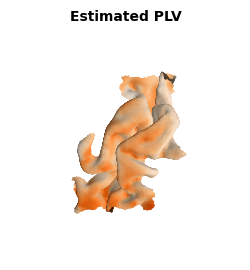

In [19]:
tempdata   = plv_roi_surf_from_mollweide_interp
value_min, value_max = 0.004, 0.03
color_numPoint = 30000
color_name     = 'Oranges'
cmap           = plt.get_cmap(color_name, lut=color_numPoint) # .reversed() 
list_color = plot_functions.calc_list_color(value_data=tempdata, value_min=value_min, value_max=value_max, \
                                           color_name=color_name, color_numPoint=color_numPoint, method='symmetry')
custom_cmap = ListedColormap(list_color)
# plot figures 
fig, ax = plt.subplots(1, 1, figsize=(3, 3), subplot_kw={'projection': '3d'})
polycol3d = Poly3DCollection([vertices_0[face] for face in faces_0], facecolors=list_color, edgecolors=list_color, shade=True)
ax.add_collection3d(polycol3d)
ax.set_xlim(-80, 10)
ax.set_ylim(-20, 40)
ax.set_zlim(25, 80)
ax.view_init(45, 180)
ax.axis('off')
ax.axis('equal')
ax.set_title('Estimated PLV', fontsize=10, weight='bold')
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=value_min, vmax=value_max))
mappable.set_array([])

# save data for matlab plotting
surface = {'faces': faces_0 + 1, 'vertices': vertices_0}
value = tempdata
list_color_array = np.array([list(item[:3]) for item in list_color])
data = {'surface': surface, 'value': value, 'list_color': list_color_array}
dataPath = 'data_paper/data_matlab/L5SOI_estimated_PLV_from_uniformResults_smooth.mat'
if not os.path.exists(dataPath):
    scipy.io.savemat(dataPath, data)

mean: 0.01237999078021074 std: 0.004098036355714121
mean1: 0.01149 std1: 0.004217891949777755


[]

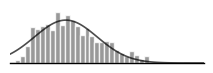

In [20]:
data = plv_roi_surf_from_mollweide
min_value, max_value, num_value = 0.004, 0.03, 40
bin_counts, bin_edges = np.histogram(data, bins=np.linspace(min_value, max_value, num_value), density=True)
bin_centers           = bin_edges[:-1] + (bin_edges[1] - bin_edges[0])/2
width                 = (bin_edges[1] - bin_edges[0])
print('mean:', data.mean(), 'std:', data.std())
# gauss fitting
if 1:
    x, y = bin_centers, bin_counts
    data = {'x': x, 'y': y}
    scipy.io.savemat('data_matlab/test.mat', data)
x     = np.linspace(min_value, max_value, 100)
paras = [[96.6, 0.01149, 0.005965], ] # R2 = 0.9027
y     = plot_functions.fit_gauss(x=x, paras=paras, order=1)
print('mean1:', 0.01149, 'std1:', 0.005965/np.sqrt(2))
# plot figure
fig, ax = plt.subplots(1, 1, figsize=(2.5, 0.7))
ax.bar(bin_centers, bin_counts, width=width, color='gray', ec='white', alpha=0.8) # #005CA2
ax.plot(x, y, linewidth=1.2, color='k', alpha=0.7)
ax.set_xlim(min_value, max_value)
ax.set_ylim(0, )
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.set_xticks([])
ax.set_yticks([])
# plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure3c-2.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

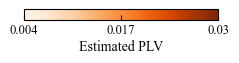

In [6]:
fig, ax = plt.subplots(1,1, figsize=(1.25, 0.14))
ax.axis('off')
cmap = plt.get_cmap('Oranges', lut=100)
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
mappable.set_array([])
cbar = fig.colorbar(mappable, cax=ax.inset_axes([0., 0, 2, 1]), location='bottom', orientation='horizontal')
cbar.set_ticks([0, 0.5, 1])
cbar.set_ticklabels(['0.004', '0.017', '0.03'], fontdict={'family': 'times new roman', 'fontsize': 9})
cbar.ax.tick_params(direction='in', pad=3)
cbar.set_label('Estimated PLV', fontdict={'family': 'times new roman', 'fontsize': 10}, labelpad=2)
# plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure3c-3.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

# Figure 4(b): Absolute error between estimated PLV and simulated PLV

-0.005290899289519226 0.002412404551080307


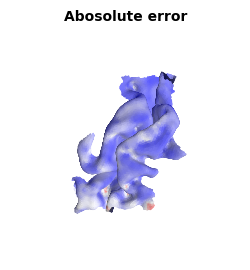

In [6]:
error =  plv_roi_surf_from_mollweide - plv_roi_surf
print(error.mean(), error.std())
rbf   = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], error, function='linear')
error_interp = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])

tempdata   = error_interp
value_min, value_max = -0.012, 0.002
color_numPoint = 30000
color_name     = 'bwr'
cmap           = plt.get_cmap(color_name, lut=color_numPoint) # .reversed() 
list_color = plot_functions.calc_list_color(value_data=tempdata, value_min=value_min, value_max=value_max, \
                                           color_name=color_name, color_numPoint=color_numPoint, method='nonsymmetry')
custom_cmap = ListedColormap(list_color)
# plot figures 
fig, ax = plt.subplots(1, 1, figsize=(3, 3), subplot_kw={'projection': '3d'})
polycol3d = Poly3DCollection([vertices_0[face] for face in faces_0], facecolors=list_color, edgecolors=list_color, shade=True)
ax.add_collection3d(polycol3d)
ax.set_xlim(-80, 10)
ax.set_ylim(-20, 40)
ax.set_zlim(25, 80)
ax.view_init(45, 180)
ax.axis('off')
ax.axis('equal')
ax.set_title('Abosolute error', fontsize=10, weight='bold')
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=value_min, vmax=value_max))
mappable.set_array([])
# save data for matlab plotting
surface = {'faces': faces_0 + 1, 'vertices': vertices_0}
value = tempdata
list_color_array = np.array([list(item[:3]) for item in list_color])
data = {'surface': surface, 'value': value, 'list_color': list_color_array}
dataPath = 'data_paper/data_matlab/L5SOI_abosolute_error_of_estimated_PLV_smooth.mat'
if not os.path.exists(dataPath):
    scipy.io.savemat(dataPath, data)

mean: -0.005427990664146084 std: 0.0020312546302923592
mean1: -0.005477 std1: 0.0016814999256616098


[]

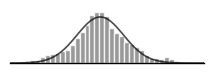

In [23]:
data = error_interp
min_value, max_value, num_value = -0.012, 0.002, 40
bin_counts, bin_edges = np.histogram(data, bins=np.linspace(min_value, max_value, num_value), density=True)
bin_centers           = bin_edges[:-1] + (bin_edges[1] - bin_edges[0])/2
width                 = (bin_edges[1] - bin_edges[0])
print('mean:', data.mean(), 'std:', data.std())
# gauss fitting
if 1:
    x, y = bin_centers, bin_counts
    data = {'x': x, 'y': y}
    scipy.io.savemat('data_matlab/test.mat', data)
x     = np.linspace(min_value, max_value, 100)
paras = [[222.5, -0.005477, 0.002378], ]
y     = plot_functions.fit_gauss(x=x, paras=paras, order=1)
print('mean1:', paras[0][1], 'std1:', paras[0][2]/np.sqrt(2))
# plot figure
fig, ax = plt.subplots(1, 1, figsize=(2.5, 0.7))
ax.bar(bin_centers, bin_counts, width=width, color='gray', ec='white', alpha=0.8) # #005CA2
ax.plot(x, y, linewidth=1.2, color='k', alpha=0.7)
ax.set_xlim(min_value, max_value)
ax.set_ylim(0, )
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.set_xticks([])
ax.set_yticks([])
# plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure3d-2.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

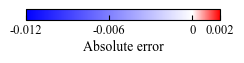

In [9]:
num_negative = int(np.abs(value_min) * 1e5)
num_positive = int(np.abs(value_max) * 1e5)
cmap = plt.get_cmap('bwr', lut=(num_negative + num_positive)*2+1)
index_negative = np.array([int(i) for i in np.linspace(0, num_negative + num_positive - 1, num_negative)])
index_positive = np.array([int(i) for i in np.linspace(num_negative + num_positive + 1, (num_negative + num_positive)*2, num_positive)])
index_all = np.hstack((index_negative, np.array([num_negative + num_positive]), index_positive))
list_color_cmap = [cmap(i) for i in index_all]


fig, ax = plt.subplots(1,1, figsize=(1.25, 0.14))
ax.axis('off')
cmap = matplotlib.colors.ListedColormap(list_color_cmap)
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=value_min, vmax=value_max))
mappable.set_array([])
cbar = fig.colorbar(mappable, cax=ax.inset_axes([0., 0, 2, 1]), location='bottom', orientation='horizontal')
cbar.set_ticks([value_min, -0.006, 0., value_max])
cbar.set_ticklabels(['-0.012', '-0.006', '0', '0.002'], fontdict={'family': 'times new roman', 'fontsize': 9})
cbar.ax.tick_params(direction='in', pad=3)
cbar.set_label('Absolute error', fontdict={'family': 'times new roman', 'fontsize': 10}, labelpad=2)
# plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure3d-3.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

# Figure 4(c): Relative error between estimated PLV and simulated PLV

-30.61175491052638 12.533720220267826


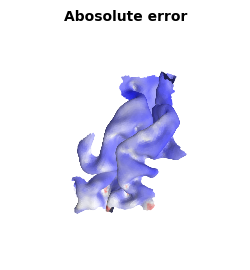

In [7]:
error_percent = 100*(plv_roi_surf_from_mollweide - plv_roi_surf) / plv_roi_surf
print(error_percent.mean(), error_percent.std())
rbf   = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], error_percent, function='linear')
error_percent_interp = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])

tempdata   = error_percent_interp
value_min, value_max = -70, 10
color_numPoint = 30000
color_name     = 'bwr'
cmap           = plt.get_cmap(color_name, lut=color_numPoint) # .reversed() 
list_color     = plot_functions.calc_list_color(value_data=tempdata, value_min=value_min, value_max=value_max, \
                                           color_name=color_name, color_numPoint=color_numPoint, method='nonsymmetry')
custom_cmap = ListedColormap(list_color)
# plot figures 
fig, ax = plt.subplots(1, 1, figsize=(3, 3), subplot_kw={'projection': '3d'})
polycol3d = Poly3DCollection([vertices_0[face] for face in faces_0], facecolors=list_color, edgecolors=list_color, shade=True)
ax.add_collection3d(polycol3d)
ax.set_xlim(-80, 10)
ax.set_ylim(-20, 40)
ax.set_zlim(25, 80)
ax.view_init(45, 180)
ax.axis('off')
ax.axis('equal')
ax.set_title('Abosolute error', fontsize=10, weight='bold')
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=value_min, vmax=value_max))
mappable.set_array([])
# save data for matlab plotting
surface = {'faces': faces_0 + 1, 'vertices': vertices_0}
value = tempdata
list_color_array = np.array([list(item[:3]) for item in list_color])
data = {'surface': surface, 'value': value, 'list_color': list_color_array}
dataPath = 'data_paper/data_matlab/L5SOI_relative_error_of_estimated_PLV_smooth.mat'
if not os.path.exists(dataPath):
    scipy.io.savemat(dataPath, data)
# scipy.io.savemat(dataPath, data)

mean: -30.61175491052638 std: 12.533720220267826
mean1: -33.11 std1: 10.146982310026956


[]

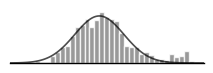

In [13]:
data = error_percent
min_value, max_value, num_value = -70, 10, 40
bin_counts, bin_edges = np.histogram(data, bins=np.linspace(min_value, max_value, num_value), density=True)
bin_centers           = bin_edges[:-1] + (bin_edges[1] - bin_edges[0])/2
width                 = (bin_edges[1] - bin_edges[0])
print('mean:', data.mean(), 'std:', data.std())
# gauss fitting
if 1:
    x, y = bin_centers, bin_counts
    data = {'x': x, 'y': y}
    scipy.io.savemat('data_matlab/test.mat', data)
x     = np.linspace(min_value, max_value, 100)
paras = [[0.0371, -33.11, 14.35], ]
y     = plot_functions.fit_gauss(x=x, paras=paras, order=1)
print('mean1:', paras[0][1], 'std1:', paras[0][2]/np.sqrt(2))
# plot figure
fig, ax = plt.subplots(1, 1, figsize=(2.5, 0.7))
ax.bar(bin_centers, bin_counts, width=width, color='gray', ec='white', alpha=0.8) # #005CA2
ax.plot(x, y, linewidth=1.2, color='k', alpha=0.7)
ax.set_xlim(min_value, max_value)
ax.set_ylim(0, )
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.set_xticks([])
ax.set_yticks([])
# plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure3e-2.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

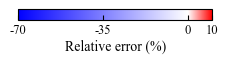

In [12]:
num_negative = int(np.abs(value_min) * 1e2)
num_positive = int(np.abs(value_max) * 1e2)
cmap = plt.get_cmap('bwr', lut=(num_negative + num_positive)*2+1)
index_negative = np.array([int(i) for i in np.linspace(0, num_negative + num_positive - 1, num_negative)])
index_positive = np.array([int(i) for i in np.linspace(num_negative + num_positive + 1, (num_negative + num_positive)*2, num_positive)])
index_all = np.hstack((index_negative, np.array([num_negative + num_positive]), index_positive))
list_color_cmap = [cmap(i) for i in index_all]


fig, ax = plt.subplots(1,1, figsize=(1.25, 0.14))
ax.axis('off')
cmap = matplotlib.colors.ListedColormap(list_color_cmap)
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=value_min, vmax=value_max))
mappable.set_array([])
cbar = fig.colorbar(mappable, cax=ax.inset_axes([0., 0, 2, 1]), location='bottom', orientation='horizontal')
cbar.set_ticks([value_min, -35, 0., value_max])
cbar.set_ticklabels(['-70', '-35', '0', '10'], fontdict={'family': 'times new roman', 'fontsize': 9})
cbar.ax.tick_params(direction='in', pad=3)
cbar.set_label('Relative error (%)', fontdict={'family': 'times new roman', 'fontsize': 10}, labelpad=2)
# plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figure3e-3.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')

# Figure S5: Estimated error in three structures and four regions, as well as correlation to simulated PLV

In [4]:
# layer 5 roi surface mesh with 1000 elements
L5_surf_roi  = simnibs.read_stl(r'data_paper\Layer5_roi_pymeshlab.stl')
faces        = L5_surf_roi.elm.node_number_list[:, 0:3] - 1
faces_center = L5_surf_roi.elements_baricenters().value
vertices     = L5_surf_roi.nodes.node_coord
cell_normals = L5_surf_roi.triangle_normals().value
# layer 5 roi surface mesh without discretized
L5_surf        = simnibs.read_msh(r'data_paper\Layer5_roi.msh')
faces_0        = L5_surf.elm.node_number_list[:, 0:3] - 1
faces_center_0 = L5_surf.elements_baricenters().value
vertices_0     = L5_surf.nodes.node_coord
cell_normals_0 = L5_surf.triangle_normals().value
# Load E-fields at the center of elements (soma)
dataPath = r'data_paper\Layer5_popCell_interpolate_Evector_forSectionAndSegment.npy'
data     = np.load(dataPath, allow_pickle=True).item()
popCell_Einterp_section = data['popCell_Einterp_section']
elm_Evectors    = np.array([item[0] for item in popCell_Einterp_section]) # index 0 for soma compartment
elm_Emagnitudes = np.linalg.norm(elm_Evectors, axis=1)
rbf                    = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], elm_Emagnitudes, function='linear')
elm_Emagnitudes_interp = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])
# Load PLV and PPh, fr (1000 elements, uniform E-field extracted from the soma, scaling factor is 2)
dataPath = r'data_paper/L5PC_Clone4_PLV_ROISurf_tACS2mA10Hz_scalingFactor2_1000cells_uniform.p'
data     = pickle.load(open(dataPath, 'rb'))
plv_roi_surf = np.array([item[0] for item in data])
pph_roi_surf = np.array([(np.angle(item[2])*180/np.pi + 360) % 360 for item in data])
fr_roi_surf  = np.array([item[5] for item in data])
rbf                 = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], plv_roi_surf, function='linear')
plv_roi_surf_interp = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])
rbf                 = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], pph_roi_surf, function='linear')
pph_roi_surf_interp = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])
rbf                 = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], fr_roi_surf, function='linear')
fr_roi_surf_interp  = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])
# Load data: neural entrainment across the full range of possible field directions
dataPath = 'data_paper/L5PC_Clone4_PLV_sensitivity_to_Efield_410_directions_1mVmm_10Hz.p'
data_410_direction = pickle.load(open(dataPath, 'rb'))
plv_410_direction  = np.array([item[0] for item in data_410_direction])
list_theta         = np.deg2rad(np.arange(0, 181, 10))
list_phi           = np.deg2rad(np.arange(0, 361, 15))
matrix_plv         = np.zeros((len(list_theta), len(list_phi)))
matrix_plv[0, :]  += plv_410_direction[0]
num = 1
for i in range(1, len(list_theta) - 1):
    for j in range(len(list_phi) - 1):
        matrix_plv[i, j] = plv_410_direction[num]
        num += 1
    matrix_plv[i, -1] = plv_410_direction[num - len(list_phi) + 1]
matrix_plv[-1, :] += plv_410_direction[-1]
# calculate the E-field direction relative to neuron models in layer 5 SIO
list_theta_layer5, list_phi_layer5 = plot_functions.calc_ROISurfEvec_toOriginEfieldDirection(elm_Evectors, cell_normals)
list_phi_layer5[list_phi_layer5 < 0] += 360
list_theta_layer5 = np.deg2rad(list_theta_layer5)
list_phi_layer5   = np.deg2rad(list_phi_layer5)
# interpolate the plv in layer 5 SOI from 2D PLV-direction maps
interp2d = scipy.interpolate.interp2d(list_phi, list_theta, matrix_plv, kind='linear')
plv_roi_surf_from_mollweide = np.array([interp2d(xi, yi) for xi, yi in zip(list_phi_layer5, list_theta_layer5)]).squeeze()
plv_roi_surf_from_mollweide = plv_roi_surf_from_mollweide * elm_Emagnitudes * 2
rbf = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], plv_roi_surf_from_mollweide, function='linear')
plv_roi_surf_from_mollweide_interp = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])
# absolute error
error        = plv_roi_surf_from_mollweide - plv_roi_surf
rbf          = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], error, function='linear')
error_interp = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])
# relative error
error_percent        = 100*(plv_roi_surf_from_mollweide - plv_roi_surf) / plv_roi_surf
rbf                  = scipy.interpolate.Rbf(faces_center[:,0], faces_center[:,1], faces_center[:,2], error_percent, function='linear')
error_percent_interp = rbf(faces_center_0[:,0], faces_center_0[:,1], faces_center_0[:,2])

# Load three structures indices
data_index          = np.load('data/pre_central_post_indices_original.npy', allow_pickle=True).item()
precentral_indices  = data_index['precentral_indices']
central_indices     = data_index['central_indices']
postcentral_indices = data_index['postcentral_indices']
# Load three structures indices after downsampling
data_index                 = np.load('data/pre_central_post_indices_downsampling.npy', allow_pickle=True).item()
precentral_indices_sample  = data_index['precentral_indices']
central_indices_sample     = data_index['central_indices']
postcentral_indices_sample = data_index['postcentral_indices']
# Load four regions indices
indices_four_regions = np.load('data_paper/indices_of_four_regions_in_layer5SOI.npy', allow_pickle=True)
indices_four_regions = indices_four_regions.item()
indicesI             = indices_four_regions['indices_region_I']
indicesII            = indices_four_regions['indices_region_II']
indicesIII           = indices_four_regions['indices_region_III']
indicesIV            = indices_four_regions['indices_region_IV']
# Load four regions indices after downsampling
indices_four_regions = np.load('data/indices_of_four_regions_in_layer5SOI_downsampling.npy', allow_pickle=True)
indices_four_regions = indices_four_regions.item()
indicesI_sample      = indices_four_regions['indices_region_I']
indicesII_sample     = indices_four_regions['indices_region_II']
indicesIII_sample    = indices_four_regions['indices_region_III']
indicesIV_sample     = indices_four_regions['indices_region_IV']
# print
print(plv_roi_surf_from_mollweide.mean(), plv_roi_surf_from_mollweide.std())
print(error.mean(), error.std())
print(error_percent.mean(), error_percent.std())

0.01237999078021074 0.004098036355714121
-0.005290899289519226 0.002412404551080307
-30.61175491052638 12.533720220267826


In [5]:
# linear regression
x, y = plv_roi_surf_from_mollweide, plv_roi_surf
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
# xfit_upward = np.linspace(0, 1.05, 2000)
# yfit_upward = slope * xfit_upward + intercept
R2_upward   = r_value ** 2
print(f"  upward E-field: R2={R2_upward}, pvalue={p_value}")

x, y = error, plv_roi_surf_from_mollweide
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
# xfit_upward = np.linspace(0, 1.05, 2000)
# yfit_upward = slope * xfit_upward + intercept
R2_upward   = r_value ** 2
print(f"  upward E-field: R2={R2_upward}, pvalue={p_value}")

x, y = error_percent, plv_roi_surf_from_mollweide
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
# xfit_upward = np.linspace(0, 1.05, 2000)
# yfit_upward = slope * xfit_upward + intercept
R2_upward   = r_value ** 2
print(f"  upward E-field: R2={R2_upward}, pvalue={p_value}")

  upward E-field: R2=0.6899577230143561, pvalue=5.031503416368198e-256
  upward E-field: R2=0.0661130973130229, pvalue=1.4555867549522758e-16
  upward E-field: R2=0.5139447549319471, pvalue=1.594150742543519e-158


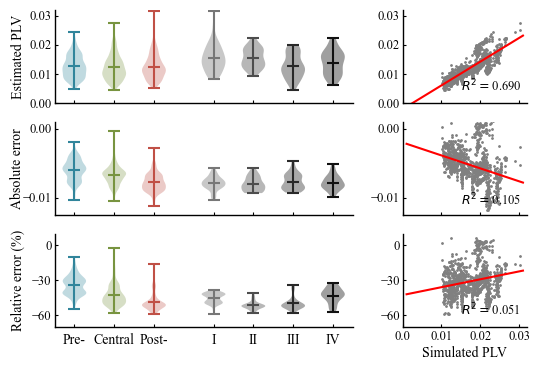

In [7]:
fig = plt.figure(figsize=(5.5, 3.8))
shape0, shape1 = 3, 3
ax0 = plt.subplot2grid(shape=(shape0, shape1), loc=(0,0), rowspan=1, colspan=2)
ax1 = plt.subplot2grid(shape=(shape0, shape1), loc=(0,2), rowspan=1, colspan=1)
ax2 = plt.subplot2grid(shape=(shape0, shape1), loc=(1,0), rowspan=1, colspan=2)
ax3 = plt.subplot2grid(shape=(shape0, shape1), loc=(1,2), rowspan=1, colspan=1)
ax4 = plt.subplot2grid(shape=(shape0, shape1), loc=(2,0), rowspan=1, colspan=2)
ax5 = plt.subplot2grid(shape=(shape0, shape1), loc=(2,2), rowspan=1, colspan=1)
width = 0.6
data  = plv_roi_surf_from_mollweide
pc1   = ax0.violinplot([data[precentral_indices_sample], data[central_indices_sample], data[postcentral_indices_sample]], positions=[0, 1, 2], widths=width, showmeans=True)
pc2   = ax0.violinplot([data[indicesI_sample], data[indicesII_sample], data[indicesIII_sample], data[indicesIV_sample]], positions=np.array([0, 1, 2, 3])+3.5, widths=width, showmeans=True)

data  = error_interp
pc3   = ax2.violinplot([data[precentral_indices_sample], data[central_indices_sample], data[postcentral_indices_sample]], positions=[0, 1, 2], widths=width, showmeans=True)
pc4   = ax2.violinplot([data[indicesI_sample], data[indicesII_sample], data[indicesIII_sample], data[indicesIV_sample]], positions=np.array([0, 1, 2, 3])+3.5, widths=width, showmeans=True)

data  = error_percent_interp
pc5   = ax4.violinplot([data[precentral_indices_sample], data[central_indices_sample], data[postcentral_indices_sample]], positions=[0, 1, 2], widths=width, showmeans=True)
pc6   = ax4.violinplot([data[indicesI_sample], data[indicesII_sample], data[indicesIII_sample], data[indicesIV_sample]], positions=np.array([0, 1, 2, 3])+3.5, widths=width, showmeans=True)

list_colors = ['#31859B', '#789440', '#C05046']
for pc in [pc1, pc3, pc5]:
    for item in ['cmeans', 'cmaxes', 'cmins', 'cbars']:
        pc[item].set_color(list_colors)
    for i in range(len(list_colors)):
        pc['bodies'][i].set_facecolor(list_colors[i])
        pc['bodies'][i].set_alpha(0.3)

list_colors = ['#777777', '#4D4D4D', '#292929', '#111111']
for pc in [pc2, pc4, pc6]:
    for item in ['cmeans', 'cmaxes', 'cmins', 'cbars']:
        pc[item].set_color(list_colors)
    for i in range(len(list_colors)):
        pc['bodies'][i].set_facecolor(list_colors[i])
        pc['bodies'][i].set_alpha(0.4)

# correlation analysis
#
x, y = plv_roi_surf, plv_roi_surf_from_mollweide
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
xfit = np.linspace(0.001, 0.031, 200)
yfit = slope * xfit + intercept
R2   = r_value ** 2
ax1.scatter(x, y, s=1, color='gray')
ax1.plot(xfit, yfit, lw=1.5, color='r')
ax1.text(0.015, 0.004, r'$R^2=$%.3f' % R2, fontsize=9, family='times new roman')
#
x, y = plv_roi_surf, error
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
xfit = np.linspace(0.001, 0.031, 200)
yfit = slope * xfit + intercept
R2   = r_value ** 2
ax3.scatter(x, y, s=1, color='gray')
ax3.plot(xfit, yfit, lw=1.5, color='r')
ax3.text(0.015, -0.011, r'$R^2=$%.3f' % R2, fontsize=9, family='times new roman')
#
x, y = plv_roi_surf, error_percent
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
xfit = np.linspace(0.001, 0.031, 200)
yfit = slope * xfit + intercept
R2   = r_value ** 2
ax5.scatter(x, y, s=1, color='gray')
ax5.plot(xfit, yfit, lw=1.5, color='r')
ax5.text(0.015, -60, r'$R^2=$%.3f' % R2, fontsize=9, family='times new roman')

for item in [ax0, ax2, ax4]:
    item.set_xlim(-0.5, 7)
    item.set_xticks(np.hstack((np.array([0, 1, 2]), np.array([0, 1, 2, 3])+3.5)), labels=["Pre-", 'Central', "Post-", "I", 'II', "III", "IV"])
    item.set_xticklabels([])
    item.spines['right'].set_color('none')
    item.spines['top'].set_color('none')
    item.spines['bottom'].set_linewidth(1)
    item.spines['left'].set_linewidth(1)
    item.tick_params(axis='x', direction='in', labelsize=9, labelfontfamily='times new roman', labelrotation=0, pad=3, length=2)
    item.tick_params(axis='y', direction='in', labelsize=9, labelfontfamily='times new roman', pad=2, length=2)
ax4.set_xticks(np.hstack((np.array([0, 1, 2]), np.array([0, 1, 2, 3])+3.5)), labels=["Pre-", 'Central', "Post-", "I", 'II', "III", "IV"])
ax4.tick_params(axis='x', direction='in', labelsize=10, labelfontfamily='times new roman', labelrotation=0, pad=4, length=2)

for item in [ax1, ax3, ax5]:
    item.set_xlim(0, 0.032)
    item.set_xticks(np.arange(0, 0.032, 0.01))
    item.set_xticklabels([])
    item.spines['right'].set_color('none')
    item.spines['top'].set_color('none')
    item.spines['bottom'].set_linewidth(1)
    item.spines['left'].set_linewidth(1)
    item.tick_params(axis='x', direction='in', labelsize=9, labelfontfamily='times new roman', labelrotation=0, pad=3, length=2)
    item.tick_params(axis='y', direction='in', labelsize=9, labelfontfamily='times new roman', pad=2, length=2)
ax5.set_xticks(np.arange(0, 0.032, 0.01), labels=['0.0', '0.01', '0.02', '0.03'])
ax5.tick_params(axis='x', direction='in', labelsize=9, labelfontfamily='times new roman', labelrotation=0, pad=3, length=2)

for item in [ax0, ax1]:
    item.set_ylim(0, 0.032)
    item.set_yticks(np.arange(0, 0.032, 0.01))
for item in [ax2, ax3]:
    item.set_ylim(-0.0125, 0.001)
    item.set_yticks([-0.01, 0.])
for item in [ax4, ax5]:
    item.set_ylim(-70, 10)
    item.set_yticks([-60, -30, 0])

ax0.set_ylabel('Estimated PLV', fontsize=10, family='times new roman', labelpad=3)
ax2.set_ylabel('Absolute error', fontsize=10, family='times new roman', labelpad=-1)
ax4.set_ylabel('Relative error (%)', fontsize=10, family='times new roman', labelpad=5)
ax5.set_xlabel('Simulated PLV', fontsize=10, family='times new roman', labelpad=2)

plt.tight_layout(w_pad=1.3, h_pad=0.8)
plt.savefig(r'C:\Users\Snowp\Desktop\paperFigures\figureS3c.tif',format='tif',transparent=True,dpi=600,bbox_inches='tight')